#### Student Name: Ladipo Ipadeola
# *Student Matric No: 25120133014*


## Customer Churn Analysis: Outlier Detection & Advanced Performance Enhancement

---

This notebook provides a comprehensive solution for:
- **Exploratory Data Analysis** to understand the churn dataset
- **Outlier Detection** using 3 different methods
---
### Dataset Overview

**File:** Customer-Churn.csv

**Target Variable:** Churn (Yes/No)


### Environment Setup

In [1]:
# Install all required Python packages for data analysis, clustering, and visualization
# To install the commented-out packages, remove the '#' from the below code
# !pip install pandas numpy matplotlib seaborn scipy scikit-learn


In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist

# Styling
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" All libraries imported successfully!")

 All libraries imported successfully!


In [3]:
# Load dataset and initial inspection

df = pd.read_csv('Customer-Churn.csv')

print("="*70)
print("DATASET INITIAL INSPECTION")
print("="*70)
print(f"\n Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n Column Names:\n{df.columns.tolist()}")


print(f"\n First 5 rows:")
display(df.head())

print(f"\n Data Types:")
display(df.dtypes.value_counts())

print(f"\n Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    display(missing[missing > 0])
else:
    print("No missing values detected!")
    
print(f"\n Target Distribution:")
display(df['Churn'].value_counts())
print(f"   Churn Rate: {(df['Churn']=='Yes').sum()/len(df)*100:.2f}%")

DATASET INITIAL INSPECTION

 Shape: 7043 rows × 21 columns

 Column Names:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

 First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



 Data Types:


object     18
int64       2
float64     1
Name: count, dtype: int64


 Missing Values:
No missing values detected!

 Target Distribution:


Churn
No     5174
Yes    1869
Name: count, dtype: int64

   Churn Rate: 26.54%


## Exploratory Data Analysis (EDA)

Before detecting outliers, we must understand:
- Distribution of numerical features
- Relationships between features
- Potential data quality issues

This helps us make informed decisions about outlier detection thresholds.

---

In [4]:
# Create a working copy
df_work = df.copy()

# Fix TotalCharges (has some non-numeric values)
df_work['TotalCharges'] = pd.to_numeric(df_work['TotalCharges'], errors='coerce')

# Analyze missing values in detail
missing_analysis = pd.DataFrame({
    'Column': df_work.columns,
    'Missing_Count': df_work.isnull().sum(),
    'Missing_Percentage': (df_work.isnull().sum() / len(df_work) * 100).round(2)
})
missing_analysis = missing_analysis[missing_analysis['Missing_Count'] > 0]

if len(missing_analysis) > 0:
    print("Missing Values Analysis:")
    display(missing_analysis)
    
    # Handle missing TotalCharges
    # For new customers (tenure=0), TotalCharges should be 0 or close to MonthlyCharges
    mask = df_work['TotalCharges'].isnull()
    df_work.loc[mask, 'TotalCharges'] = df_work.loc[mask, 'MonthlyCharges']
    print(f"\n Filled {mask.sum()} missing TotalCharges values")
else:
    print(" No missing values to handle")

print(f"\n Final dataset shape: {df_work.shape}")


Missing Values Analysis:


,Column,Missing_Count,Missing_Percentage
TotalCharges,TotalCharges,11,0.16



 Filled 11 missing TotalCharges values

 Final dataset shape: (7043, 21)


### Numerical Features Analysis


NUMERICAL FEATURES - DESCRIPTIVE STATISTICS
                 count         mean          std    min     25%      50%  \
tenure          7043.0    32.371149    24.559481   0.00    9.00    29.00   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.50    70.35   
TotalCharges    7043.0  2279.798992  2266.730170  18.80  398.55  1394.55   

                    75%      max  
tenure            55.00    72.00  
MonthlyCharges    89.85   118.75  
TotalCharges    3786.60  8684.80  

DISTRIBUTION METRICS

tenure:
  Skewness: 0.239 (Symmetric)
  Kurtosis: -1.387 (Light-tailed)

MonthlyCharges:
  Skewness: -0.220 (Symmetric)
  Kurtosis: -1.257 (Light-tailed)

TotalCharges:
  Skewness: 0.963 (Right-skewed)
  Kurtosis: -0.229 (Light-tailed)


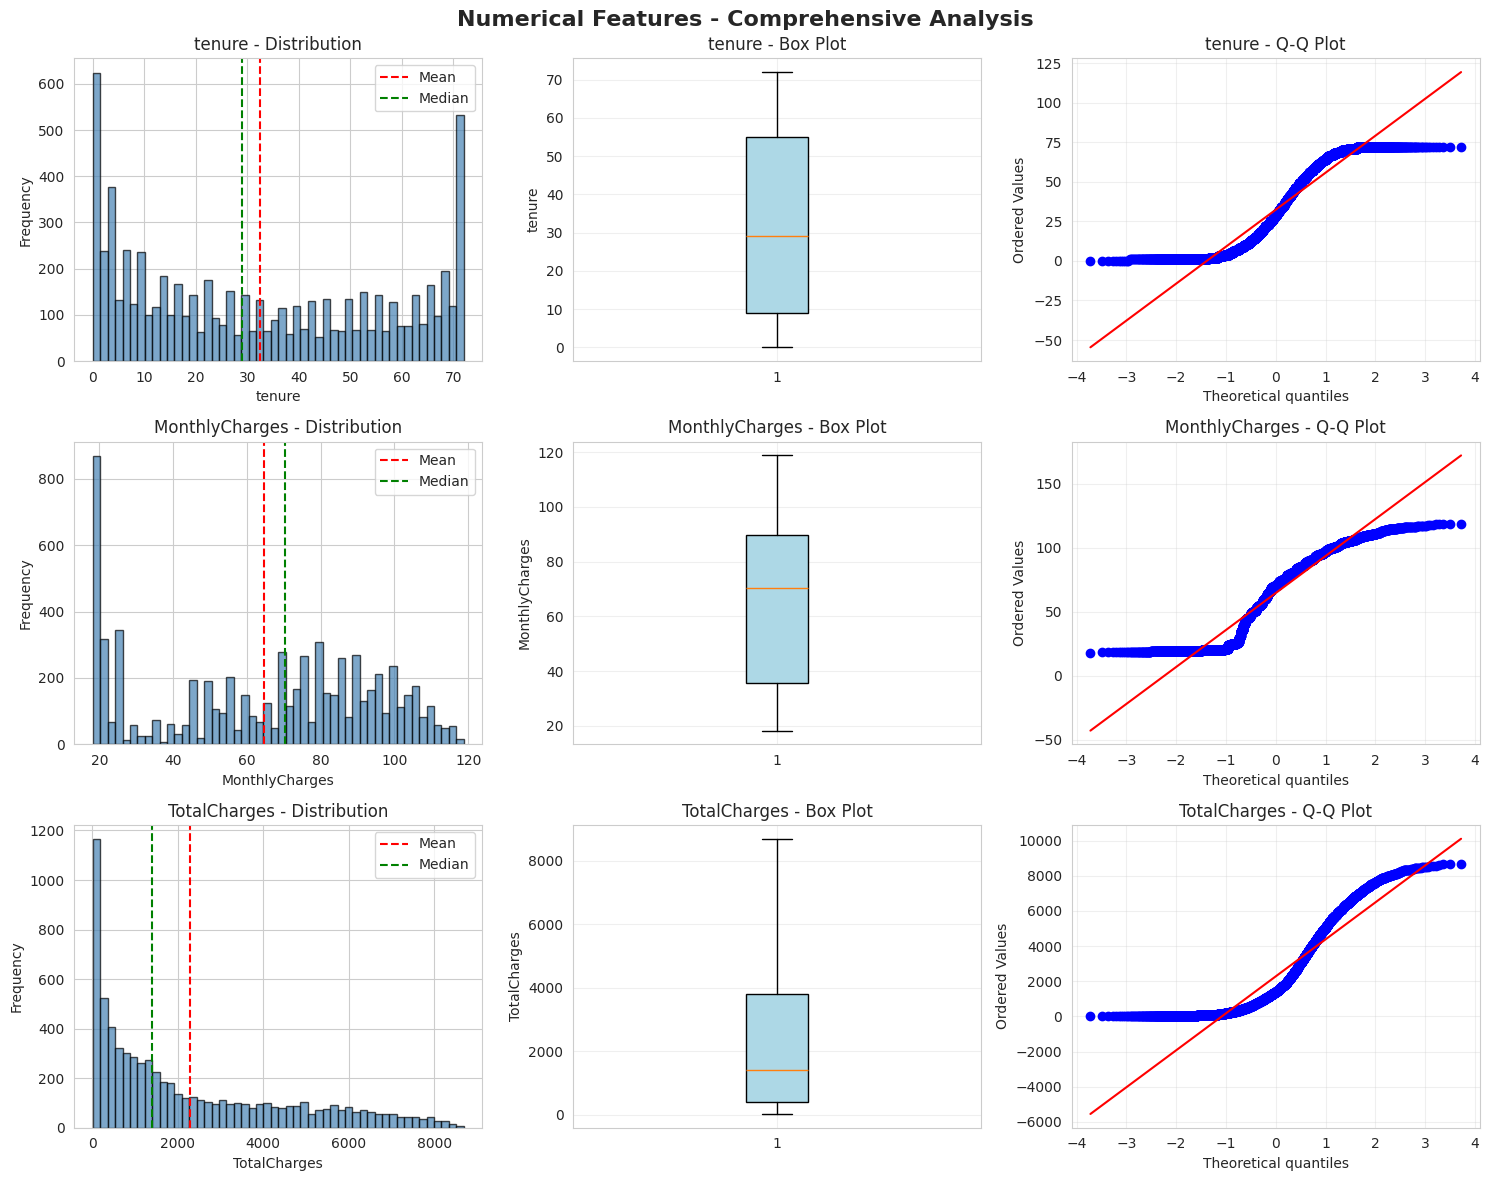

In [5]:
# Select numerical features
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_numerical = df_work[numerical_cols].copy()

# Comprehensive statistics
print("="*70)
print("NUMERICAL FEATURES - DESCRIPTIVE STATISTICS")
print("="*70)
print(X_numerical.describe().T)

# Calculate skewness and kurtosis
print("\n" + "="*70)
print("DISTRIBUTION METRICS")
print("="*70)
for col in numerical_cols:
    skew = stats.skew(X_numerical[col])
    kurt = stats.kurtosis(X_numerical[col])
    print(f"\n{col}:")
    print(f"  Skewness: {skew:.3f} {'(Right-skewed)' if skew > 0.5 else '(Symmetric)' if abs(skew) < 0.5 else '(Left-skewed)'}")
    print(f"  Kurtosis: {kurt:.3f} {'(Heavy-tailed)' if kurt > 0 else '(Light-tailed)'}")

# Visualizations
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Numerical Features - Comprehensive Analysis', fontsize=16, fontweight='bold')

for idx, col in enumerate(numerical_cols):
    # Histogram
    axes[idx, 0].hist(X_numerical[col], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx, 0].set_title(f'{col} - Distribution')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].axvline(X_numerical[col].mean(), color='red', linestyle='--', label='Mean')
    axes[idx, 0].axvline(X_numerical[col].median(), color='green', linestyle='--', label='Median')
    axes[idx, 0].legend()
    
    # Box plot
    bp = axes[idx, 1].boxplot(X_numerical[col], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    axes[idx, 1].set_title(f'{col} - Box Plot')
    axes[idx, 1].set_ylabel(col)
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Q-Q plot
    stats.probplot(X_numerical[col], dist="norm", plot=axes[idx, 2])
    axes[idx, 2].set_title(f'{col} - Q-Q Plot')
    axes[idx, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Categorical Features Analysis


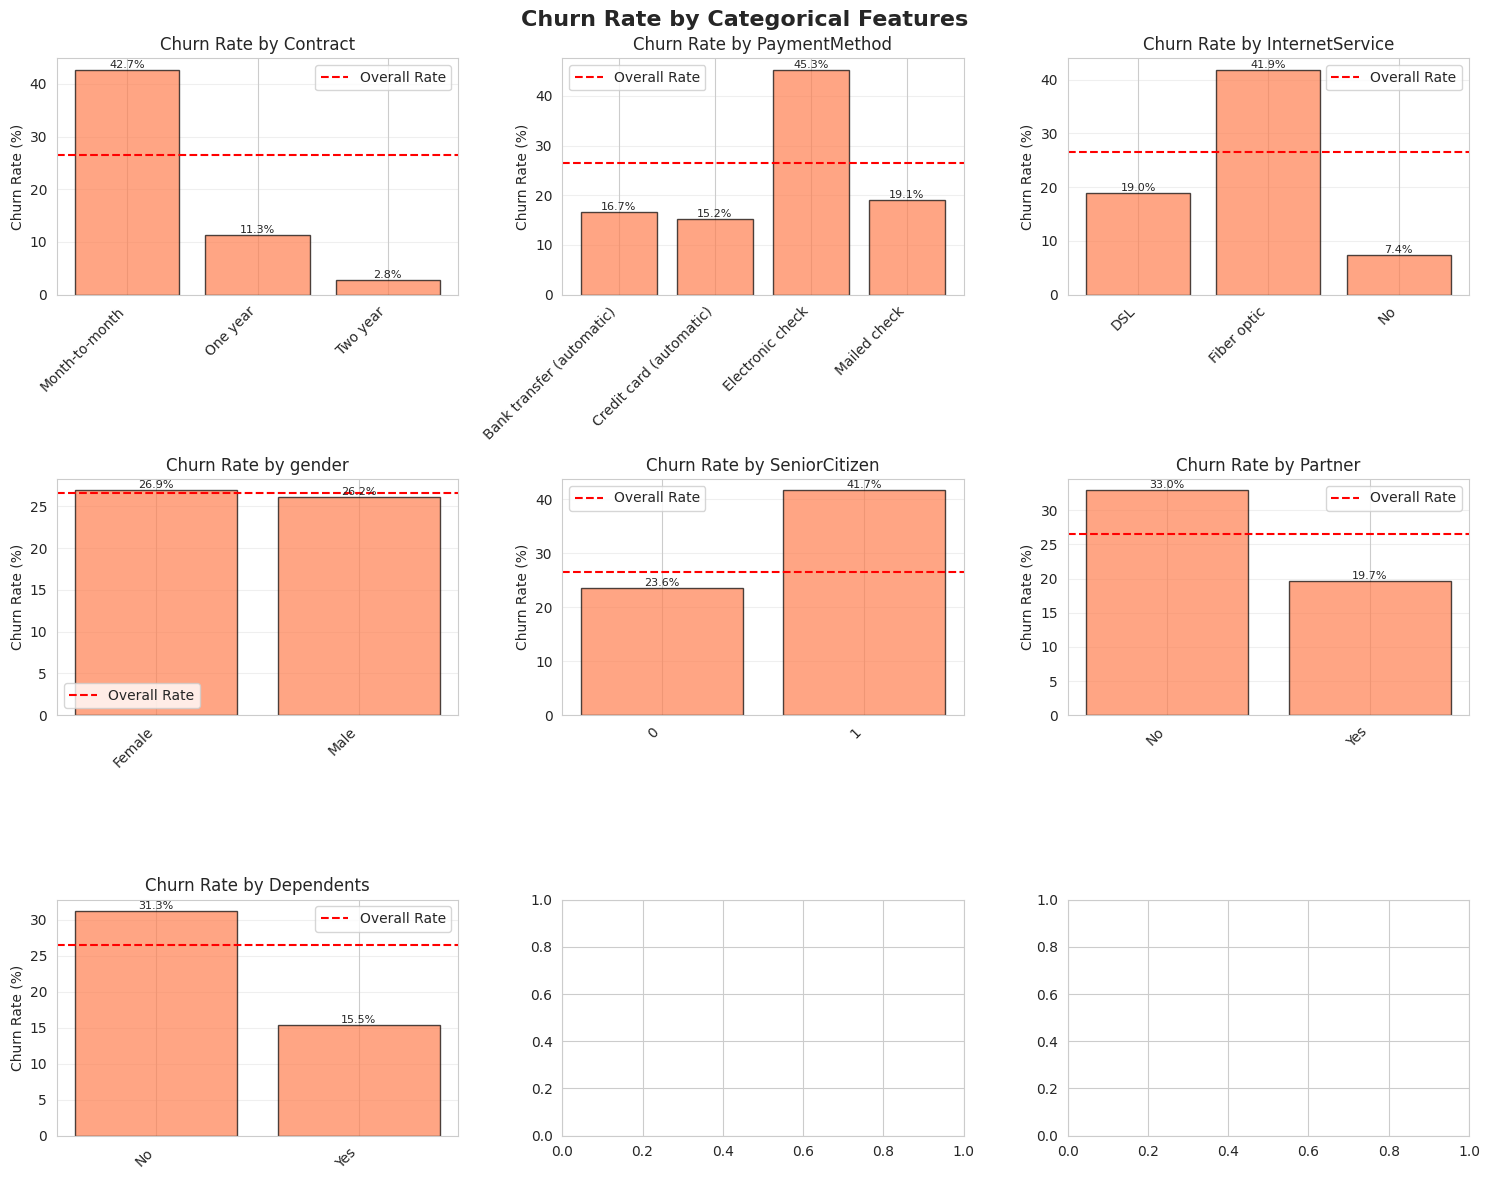


CHURN RATE BY CATEGORICAL FEATURES

Contract:


Churn,No,Yes,Churn_Rate_%
Contract,,,
Month-to-month,2220,1655,42.71
One year,1307,166,11.27
Two year,1647,48,2.83



PaymentMethod:


Churn,No,Yes,Churn_Rate_%
PaymentMethod,,,
Bank transfer (automatic),1286,258,16.71
Credit card (automatic),1290,232,15.24
Electronic check,1294,1071,45.29
Mailed check,1304,308,19.11



InternetService:


Churn,No,Yes,Churn_Rate_%
InternetService,,,
DSL,1962,459,18.96
Fiber optic,1799,1297,41.89
No,1413,113,7.40



gender:


Churn,No,Yes,Churn_Rate_%
gender,,,
Female,2549,939,26.92
Male,2625,930,26.16



SeniorCitizen:


Churn,No,Yes,Churn_Rate_%
SeniorCitizen,,,
0,4508,1393,23.61
1,666,476,41.68



Partner:


Churn,No,Yes,Churn_Rate_%
Partner,,,
No,2441,1200,32.96
Yes,2733,669,19.66



Dependents:


Churn,No,Yes,Churn_Rate_%
Dependents,,,
No,3390,1543,31.28
Yes,1784,326,15.45


In [6]:
categorical_cols = ['Contract', 'PaymentMethod', 'InternetService', 'gender', 
                    'SeniorCitizen', 'Partner', 'Dependents']

# Churn rate by categorical features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Churn Rate by Categorical Features', fontsize=16, fontweight='bold')

for idx, col in enumerate(categorical_cols):
    if idx < 9:
        row, col_idx = idx // 3, idx % 3
        churn_rate = df_work.groupby(col)['Churn'].apply(lambda x: (x=='Yes').sum()/len(x)*100)
        
        bars = axes[row, col_idx].bar(range(len(churn_rate)), churn_rate.values, 
                                       color='coral', edgecolor='black', alpha=0.7)
        axes[row, col_idx].set_xticks(range(len(churn_rate)))
        axes[row, col_idx].set_xticklabels(churn_rate.index, rotation=45, ha='right')
        axes[row, col_idx].set_ylabel('Churn Rate (%)')
        axes[row, col_idx].set_title(f'Churn Rate by {col}')
        axes[row, col_idx].axhline(y=(df_work['Churn']=='Yes').mean()*100, 
                                    color='red', linestyle='--', label='Overall Rate')
        axes[row, col_idx].legend()
        axes[row, col_idx].grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[row, col_idx].text(bar.get_x() + bar.get_width()/2., height,
                                     f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\n" + "="*70)
print("CHURN RATE BY CATEGORICAL FEATURES")
print("="*70)
for col in categorical_cols:
    print(f"\n{col}:")
    churn_by_cat = df_work.groupby(col)['Churn'].value_counts().unstack(fill_value=0)
    churn_by_cat['Churn_Rate_%'] = (churn_by_cat['Yes'] / (churn_by_cat['Yes'] + churn_by_cat['No']) * 100).round(2)
    display(churn_by_cat)

###  Data Preprocessing
Before detecting outliers, we need to prepare numerical features and handle missing values.


In [7]:
# Handle missing values in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Select numerical features for outlier detection
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_numerical = df[numerical_features].copy()

print("Numerical features statistics:")
print(X_numerical.describe())

Numerical features statistics:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2281.916928
std      24.559481       30.090047   2265.270398
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


### Method 1 K-Means Clustering for Outlier Detection
We'll use K-Means to identify outliers based on distance from cluster centroids.
Outliers are points that are far from their assigned cluster center.


K-Means Method:
  Outliers detected: 353
  Percentage: 5.01%


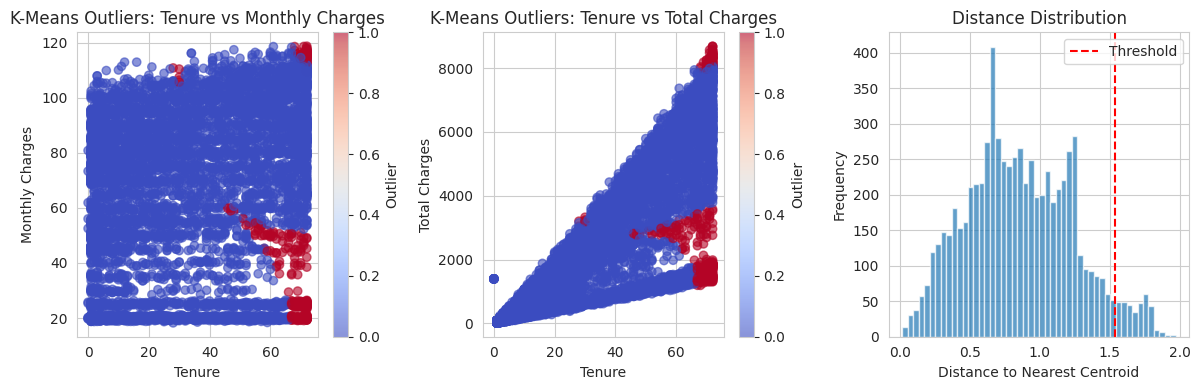

In [8]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Calculate distances to cluster centers
distances = cdist(X_scaled, kmeans.cluster_centers_, 'euclidean')
min_distances = np.min(distances, axis=1)

# Define outliers as points beyond 95th percentile distance
threshold_kmeans = np.percentile(min_distances, 95)
outliers_kmeans = min_distances > threshold_kmeans

print(f"K-Means Method:")
print(f"  Outliers detected: {outliers_kmeans.sum()}")
print(f"  Percentage: {outliers_kmeans.sum()/len(df)*100:.2f}%")

# Visualize
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(X_numerical['tenure'], X_numerical['MonthlyCharges'], 
            c=outliers_kmeans, cmap='coolwarm', alpha=0.6)
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.title('K-Means Outliers: Tenure vs Monthly Charges')
plt.colorbar(label='Outlier')

plt.subplot(1, 3, 2)
plt.scatter(X_numerical['tenure'], X_numerical['TotalCharges'], 
            c=outliers_kmeans, cmap='coolwarm', alpha=0.6)
plt.xlabel('Tenure')
plt.ylabel('Total Charges')
plt.title('K-Means Outliers: Tenure vs Total Charges')
plt.colorbar(label='Outlier')

plt.subplot(1, 3, 3)
plt.hist(min_distances, bins=50, alpha=0.7)
plt.axvline(threshold_kmeans, color='r', linestyle='--', label='Threshold')
plt.xlabel('Distance to Nearest Centroid')
plt.ylabel('Frequency')
plt.title('Distance Distribution')
plt.legend()

plt.tight_layout()
plt.show()

### Method 2: Hierarchical Clustering Approach
Hierarchical clustering builds a tree of clusters. We'll identify outliers as small clusters
or points that merge late in the hierarchy.


Hierarchical Method:
  Outliers detected: 0
  Percentage: 0.00%
  Cluster sizes: [1345 1846 2008  600 1244]


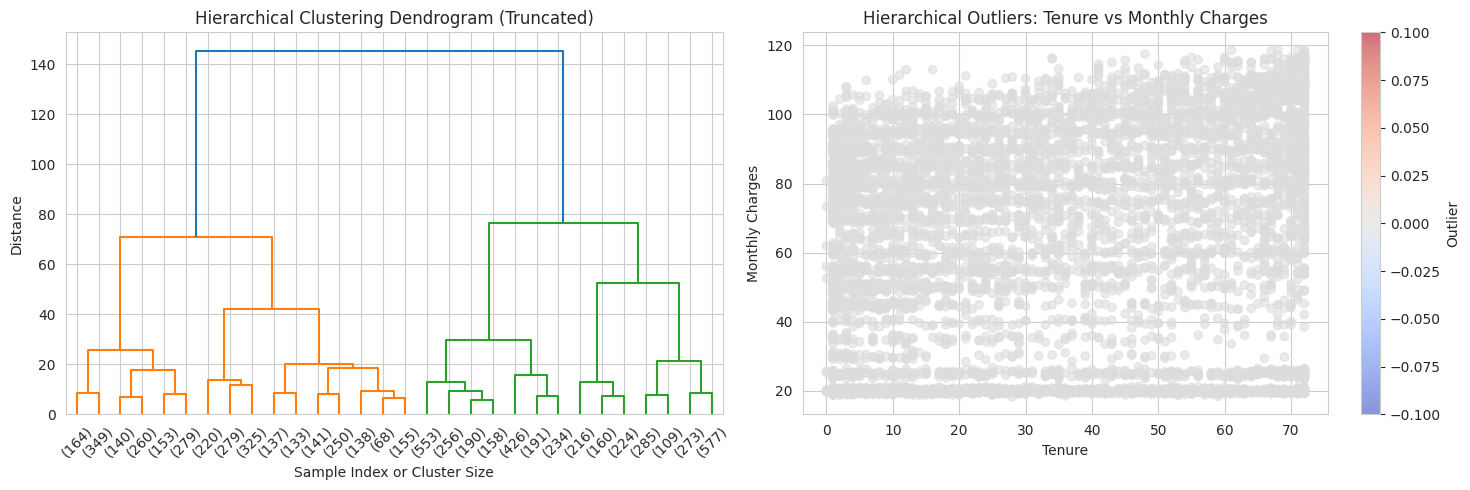

In [9]:

# Perform hierarchical clustering
linkage_matrix = linkage(X_scaled, method='ward')

# Cut tree to form clusters
n_clusters = 5
hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Identify small clusters as outliers
cluster_counts = pd.Series(hierarchical_labels).value_counts()
small_clusters = cluster_counts[cluster_counts < len(df) * 0.05].index
outliers_hierarchical = np.isin(hierarchical_labels, small_clusters)

print(f"\nHierarchical Method:")
print(f"  Outliers detected: {outliers_hierarchical.sum()}")
print(f"  Percentage: {outliers_hierarchical.sum()/len(df)*100:.2f}%")
print(f"  Cluster sizes: {cluster_counts.sort_index().values}")

# Visualize dendrogram
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram (Truncated)')

plt.subplot(1, 2, 2)
plt.scatter(X_numerical['tenure'], X_numerical['MonthlyCharges'], 
            c=outliers_hierarchical, cmap='coolwarm', alpha=0.6)
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.title('Hierarchical Outliers: Tenure vs Monthly Charges')
plt.colorbar(label='Outlier')

plt.tight_layout()
plt.show()


### Method 3: Density-Based Method (DBSCAN) for Outlier Detection
DBSCAN identifies outliers as points in low-density regions (labeled as -1).
It's particularly effective for finding irregularly shaped clusters.



DBSCAN Method:
  Outliers detected: 8
  Percentage: 0.11%
  Number of clusters found: 1


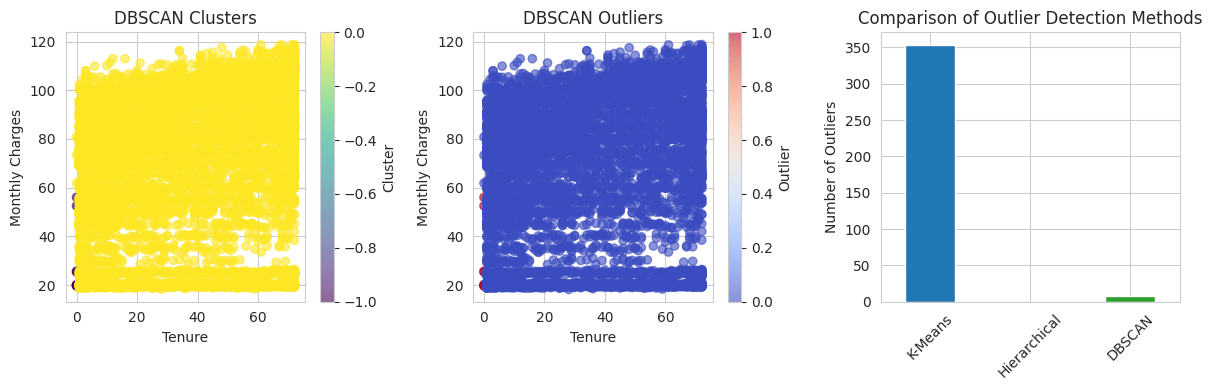

In [10]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Points labeled as -1 are outliers
outliers_dbscan = dbscan_labels == -1

print(f"\nDBSCAN Method:")
print(f"  Outliers detected: {outliers_dbscan.sum()}")
print(f"  Percentage: {outliers_dbscan.sum()/len(df)*100:.2f}%")
print(f"  Number of clusters found: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")

# Visualize
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(X_numerical['tenure'], X_numerical['MonthlyCharges'], 
            c=dbscan_labels, cmap='viridis', alpha=0.6)
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.title('DBSCAN Clusters')
plt.colorbar(label='Cluster')

plt.subplot(1, 3, 2)
plt.scatter(X_numerical['tenure'], X_numerical['MonthlyCharges'], 
            c=outliers_dbscan, cmap='coolwarm', alpha=0.6)
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.title('DBSCAN Outliers')
plt.colorbar(label='Outlier')

plt.subplot(1, 3, 3)

# Compare all three methods
comparison = pd.DataFrame({
    'K-Means': outliers_kmeans,
    'Hierarchical': outliers_hierarchical,
    'DBSCAN': outliers_dbscan
})
comparison.sum().plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Number of Outliers')
plt.title('Comparison of Outlier Detection Methods')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


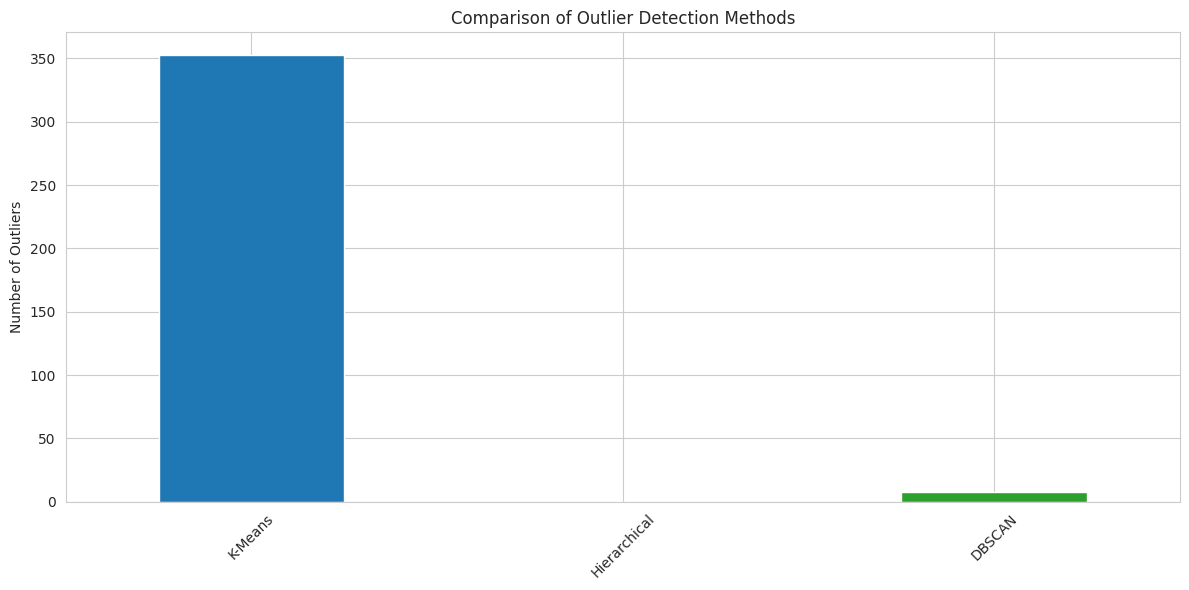

In [11]:
# Compare all three methods
comparison = pd.DataFrame({
    'K-Means': outliers_kmeans,
    'Hierarchical': outliers_hierarchical,
    'DBSCAN': outliers_dbscan
})
comparison.sum().plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Number of Outliers')
plt.title('Comparison of Outlier Detection Methods')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
